In [1]:
import fatbox

In [2]:

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1I2ct0IhTpFqWb2B9T-XPVysXolAeKD3R',
                                    dest_path='./map.png',
                                    unzip=False)

In [3]:
import numpy as np 
import networkx as nx
import pickle
import cv2
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
from scipy.spatial import distance_matrix
from skimage import feature, morphology, filters
from sklearn.preprocessing import normalize

from sys import stdout

from fatbox.preprocessing import *
from fatbox.metrics import *
from fatbox.edits import *
from fatbox.plots import *

In [14]:
img = Image.open(r"C:\Users\Lenovo\Downloads\F3_inlineF3_inline_410_stepsize_10.png").convert('L')
data = np.array(img)

data = 1-(data-np.min(data))/(np.max(data)-np.min(data))

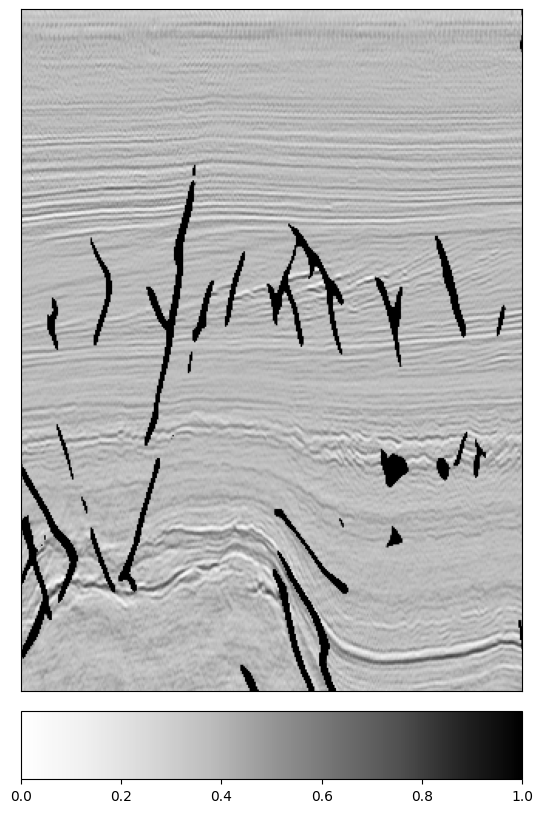

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(data, cmap='Greys', vmin=0)
plt.xticks([])
plt.yticks([])
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="10%", pad=0.2, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.show()

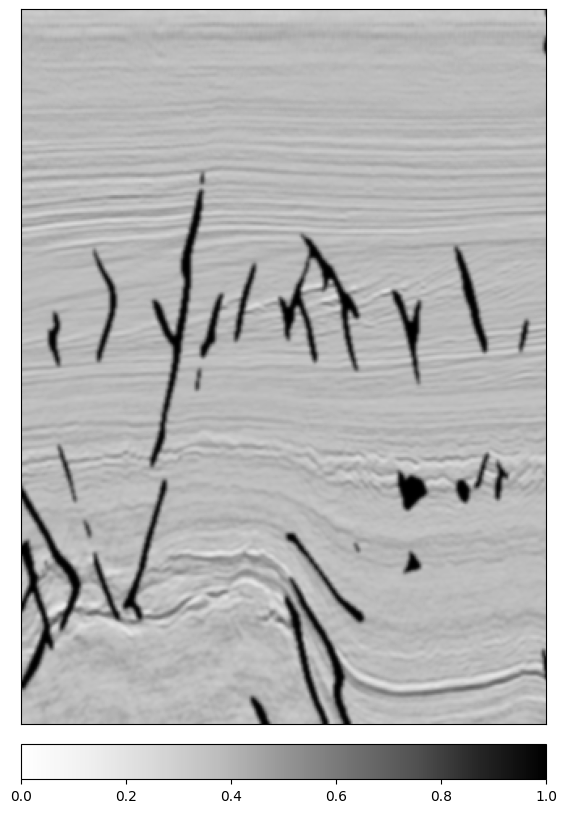

In [16]:
smoothed = filters.gaussian(data, sigma=1)

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(smoothed, cmap='Greys', vmin=0)
plt.xticks([])
plt.yticks([])
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="5%", pad=0.2, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.show()

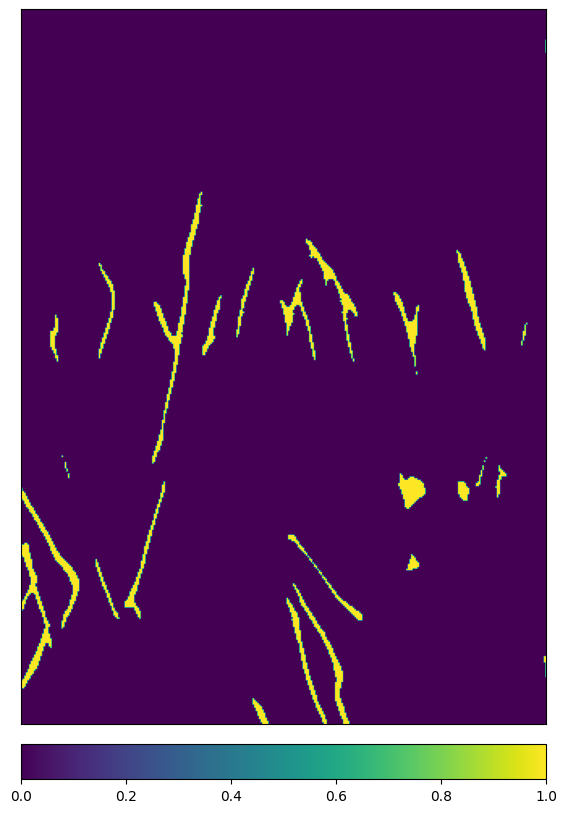

In [17]:
threshold = simple_threshold_binary(smoothed, 0.83)

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(threshold, vmin=0, vmax=1)
plt.xticks([])
plt.yticks([])
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="5%", pad=0.2, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.show()

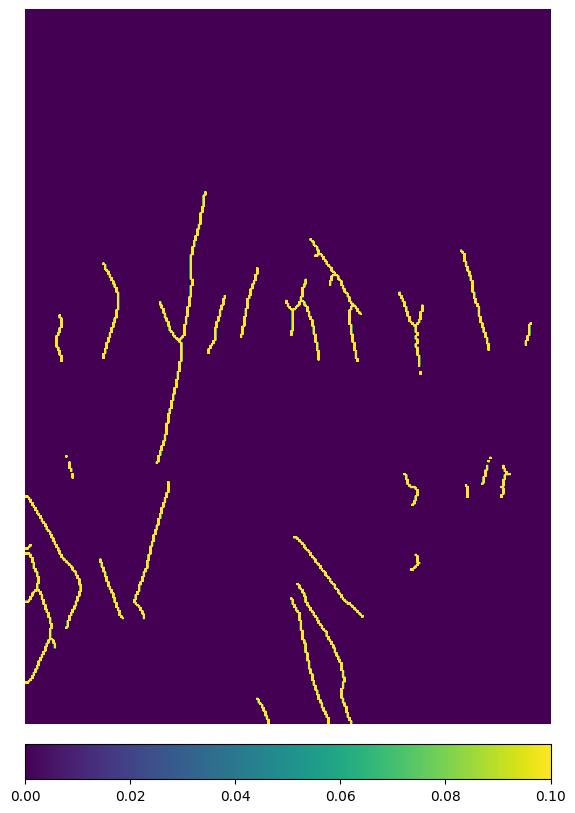

In [18]:
skeleton = skeleton_guo_hall(threshold)

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(skeleton, vmin=0, vmax=0.1)
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="5%", pad=0.2, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.show()

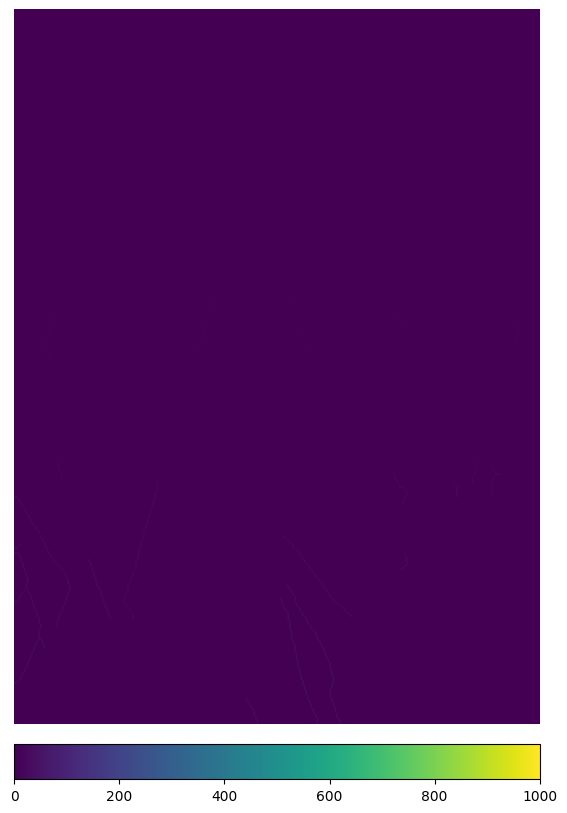

In [21]:

ret, markers = cv2.connectedComponents(skeleton)

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(markers, vmin=0, vmax=1000)
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="5%", pad=0.2, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.show()
     

In [22]:
G = nx.Graph()

node = 0
for comp in tqdm(range(1,ret)):

    points = np.transpose(np.vstack((np.where(markers==comp))))    
    
    for point in points:
        G.add_node(node)
        G.nodes[node]['pos'] = (point[1], point[0])
        G.nodes[node]['component'] = comp
        node += 1  

100%|██████████| 30/30 [00:00<00:00, 1497.15it/s]


In [19]:
for comp in tqdm(range(1,ret)): 
    
    points = [G.nodes[node]['pos'] for node in G if G.nodes[node]['component']==comp]
    nodes  = [node for node in G if G.nodes[node]['component']==comp]

    dm = distance_matrix(points, points)  
    
    
    for n in range(len(points)):
        # print(n)
        for m in range(len(points)):
            if dm[n,m]<1.5 and n != m:
                G.add_edge(nodes[n],nodes[m])

100%|██████████| 4233/4233 [10:06<00:00,  6.98it/s]  


AttributeError: 'bool' object has no attribute 'items'

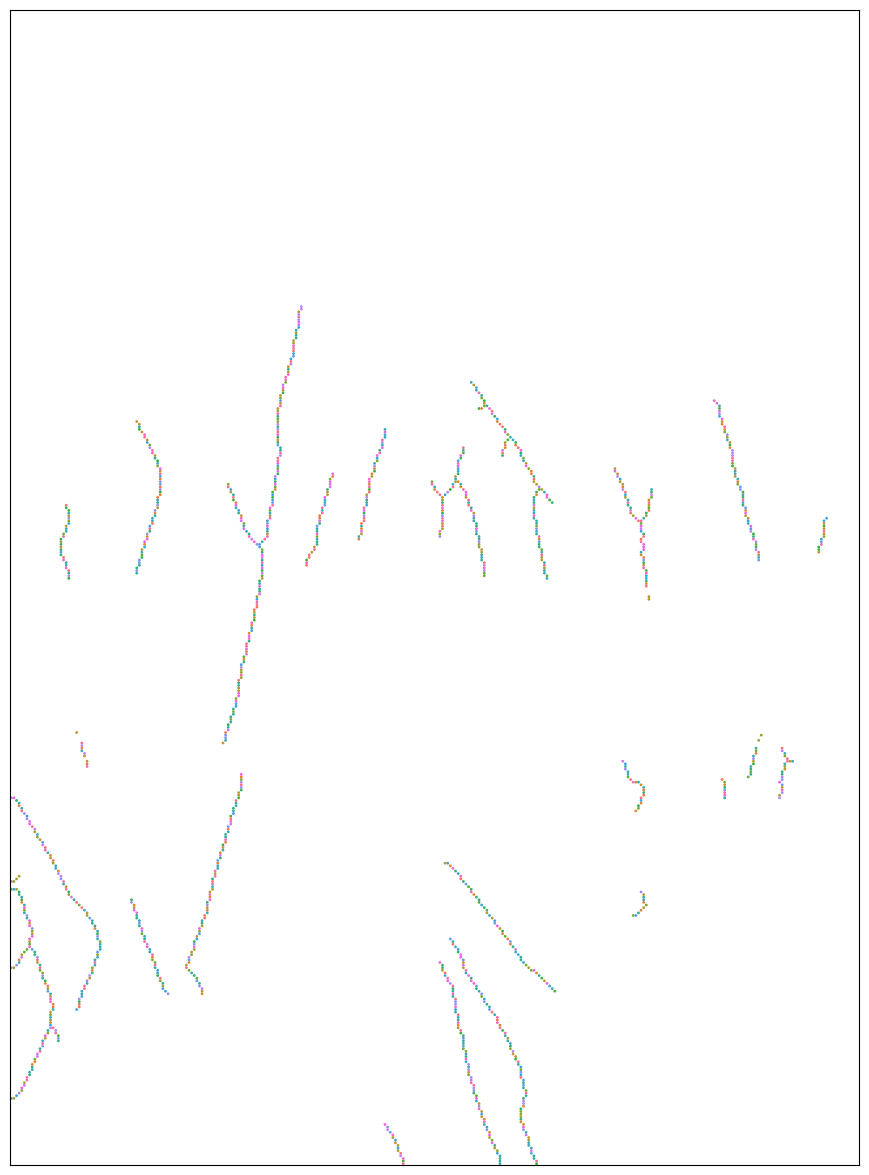

In [23]:
G = label_components(G)

fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.imshow(np.zeros_like(data), 'gray_r', vmin=0)
plot_components(G, labels=False, node_size=1, ax=ax)
ax.set_xlim(0,data.shape[1])
ax.set_ylim(data.shape[0],0)
plt.show()

In [24]:
G = split_triple_junctions(G, 25)
G = label_components(G)

AttributeError: 'bool' object has no attribute 'items'

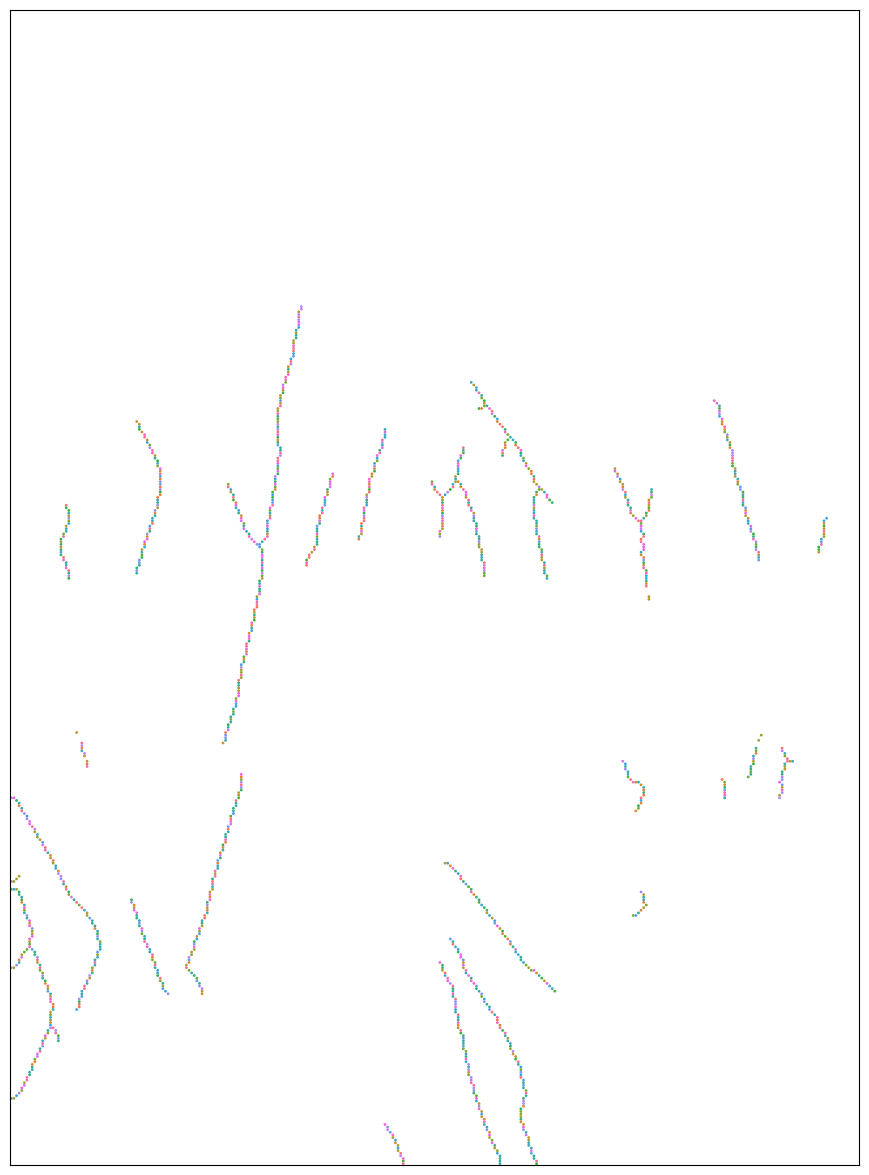

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.imshow(np.zeros_like(data), 'gray_r', vmin=0)
plot_components(G, labels=False, node_size=1, ax=ax)
ax.set_xlim(0,data.shape[1])
ax.set_ylim(data.shape[0],0)
plt.show()

In [26]:
G = compute_edge_length(G)
G = calculate_strike(G, 3)

Calculate strike: 100%|██████████| 1294/1294 [00:00<00:00, 72187.66it/s]


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8468\1484380427.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = cm.get_cmap('Oranges_r', 128) # r means reversed version
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8468\1484380427.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = cm.get_cmap('Blues', 128)# combine it all


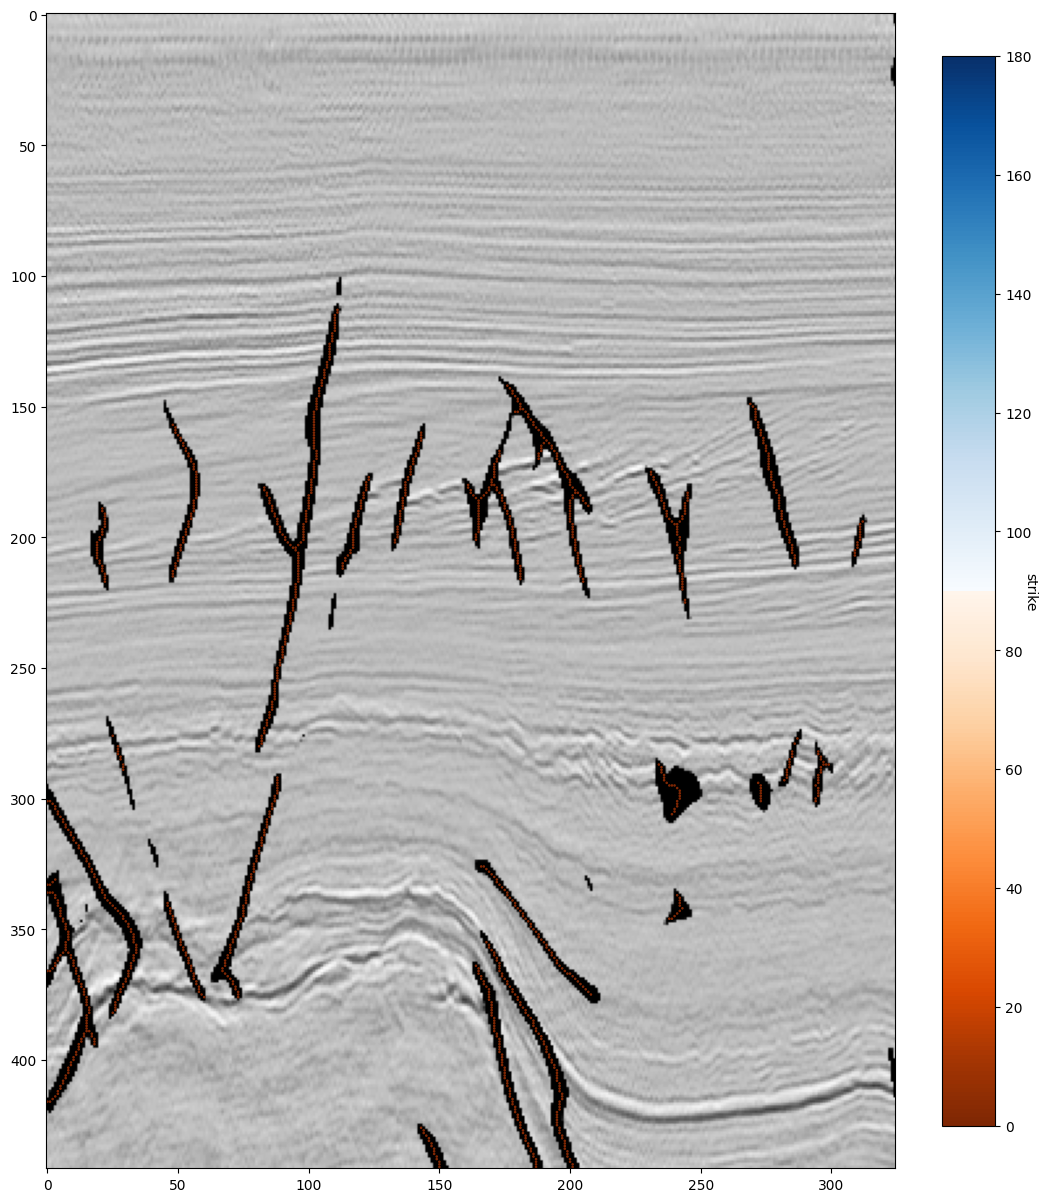

In [27]:
top = cm.get_cmap('Oranges_r', 128) # r means reversed version
bottom = cm.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = ListedColormap(newcolors, name='OrangeBlue')


fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(data, cmap='Greys', vmin=0, vmax=1)
plot_attribute(G, 'strike', cmap = orange_blue, vmin=0, vmax=180, ax=ax)
plt.show()

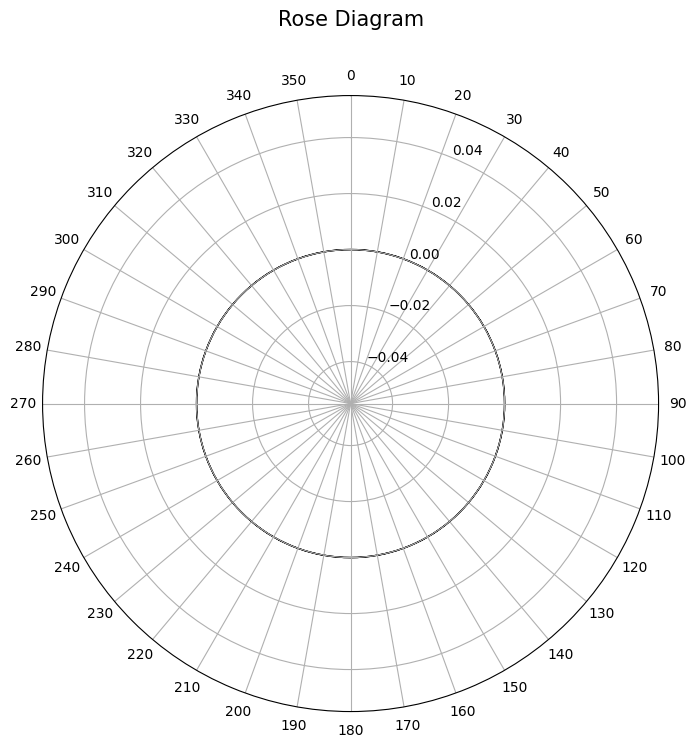

In [28]:
plot_rose(G)